Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
file_name = 'temp_anom_w_forcing.csv'

In [4]:
dataset = pd.read_csv(file_name)

In [5]:
dataset.shape

(163, 11)

In [6]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [7]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [8]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


Define the required time and target columns

In [9]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [10]:
# dataset[target_col] = dataset[target_col].astype(float)

In [11]:
# dataset.head()

Split dataset into train and test sets

In [12]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

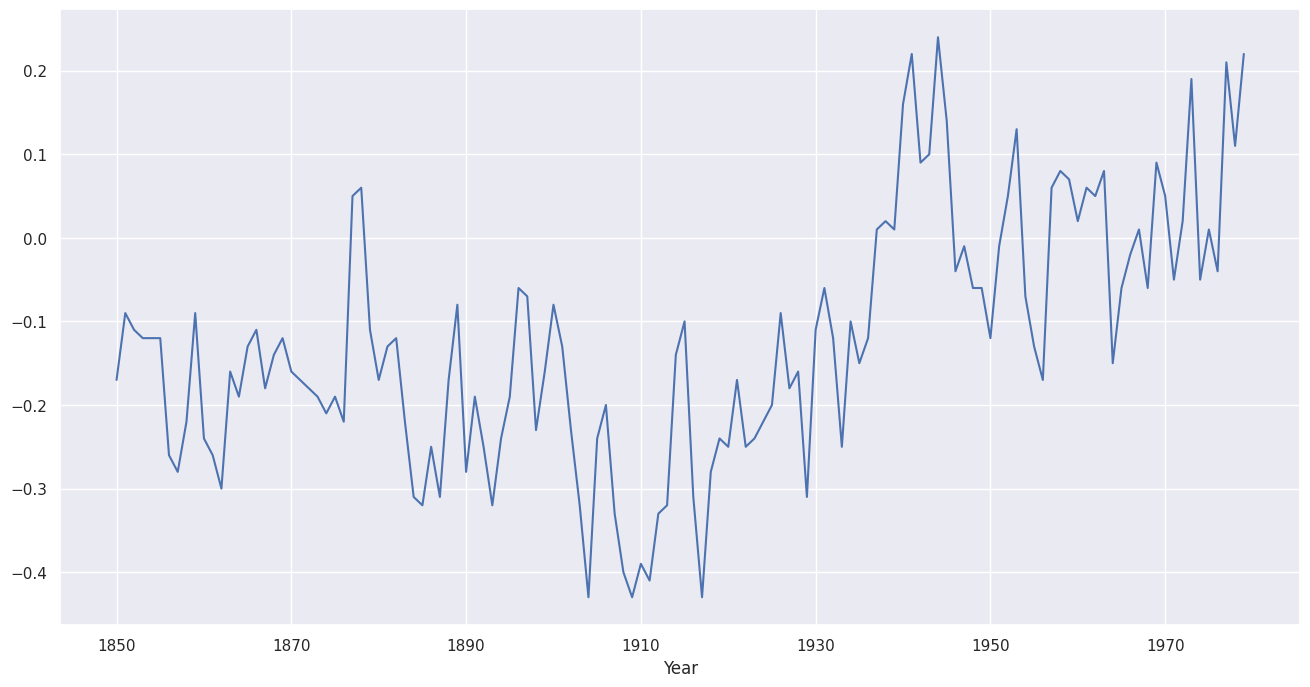

In [13]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **SYBIL Train API**

Train data: convert df to list-of-list

In [14]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [16]:
# Default model request
model_request = {
    'type': 'meta_lr',  # 'meta_wa'
    'scorers': ['smape', 'mape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer', 'params': {'strategy': 'mean'}},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_rnn'},
            {'type': 'darts_lightgbm'},
            {'type': 'darts_autotheta'},
            {'type': 'darts_autoarima'},
            {'type': 'darts_autoets'},
            # {'type': 'stats_autotheta'},
            # {'type': 'stats_autoarima'},
            # {'type': 'stats_autoets'},
        ],
    },
}

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'params': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['sybil_protocol']
host = url_dict['sybil_host']
port = url_dict['sybil_port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 27.9 ms, sys: 1.54 ms, total: 29.5 ms
Wall time: 45.2 s


In [22]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCP/hAgD44QIA7VcCABgAAADiVwIAhUsAAD+AAGVsaZOMb5Rsb4xtlARhaZRzcmGUKIwudG2UTZNhLhRscGwVb2kMdIyMeUMolHAxKE7/YgDgiQAYdYyTh1IYY2VlX5RzbnUKZChoaAECUpT/dOAAqh+UlB1jZWUSdGSMbZMTX3JfaUFrcG95aWFyuJSJBP9Lcwp0HSJLTZRO/0MBlOAAM+BwAB+UX4dplF9hlGQFlHNsbGF1TWGBaWFpbmWUc5RTb2UoBR+UaIcJOChK/10BAQEBdG+UlJRLjJROSpQAACP3AAARBh8rYn0glIVoaGhofS5hBl1hjGMJYYyUaGhiaGhdKACUaBxoaGV1aGgBQwDWwACrYKMAtpRohSicoKR0hsJoyGAfH2JkZGVyYZQobZRyZX1hZWNybG+Bcm6McnASbXRNal9lCXRSaWFUBZRoaAFgeB97CNPE5nIdXsOF60gR61zTHYr+19IfyxxRZ8pL7dNxmx861/tSYZZBh72aBwZbRXhiAUugLHQeEvRhAghtOSer/x8I/J7B7wG9CVXIAMiyhP1SPkfpNza8bR0zkZ1PnvQm3h/ICck15JzIk9W/X7JBxfg308o3zTqgbiYifJ8bVs5zMB9XRzDD66yleA7uy8Y/98X4JXObU5cTfCTmDqQrf9Oj1B8dpWtCkUQYyYt8R70sxrmDnP2X8YQWusjXwpDEWpCVJB+J041ftZ/AY0c4iO24EmVznTaT+P/yzxzyFkIF4iwAfR+AHP3dCUNxeBvcsQFI8PBnsiJkGHGB8X3COyDid2uEzx/J/uBCbXXS7hn6c8BZ04OfUPYMr5qsh2fKHfIlGE4aax9XHI3T9LNBuOcVgFtFoBJUGGXCT1Y+vsOUc2GUcwB0Xx+MdGVlk4xkX3JlcnSTKGSMLnINcpSMaGFyZW5kaWVOch99S4yUBk5khgAohT99aD+US4lhdQCUSwh1AJRfjGWMLh9kU

### **SYBIL Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [23]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

Model from Train API

In [24]:
model = train_json_out['model']

Forecast API JSON Payload

In [25]:
api_json = {
    'model': model,
    'data': test_data
}

Build URL (same as train except for the endpoint)

In [26]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [27]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 24.9 ms, sys: 0 ns, total: 24.9 ms
Wall time: 433 ms


In [28]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1980-01-01T00:00:00', 0.44704726378648973],
  ['1980-12-31T00:00:00', 0.8048105530627245],
  ['1981-12-31T00:00:00', 0.7179964338324372],
  ['1982-12-31T00:00:00', 0.7477063878859742],
  ['1983-12-31T00:00:00', 0.5060360261689159],
  ['1984-12-30T00:00:00', 0.896340494478024],
  ['1985-12-30T00:00:00', 0.7943647731674575],
  ['1986-12-30T00:00:00', 0.7327499798596699],
  ['1987-12-30T00:00:00', 0.6229803711636794],
  ['1988-12-29T00:00:00', 1.006498843837334],
  ['1989-12-29T00:00:00', 0.9137675976160897],
  ['1990-12-29T00:00:00', 0.9389031189637354],
  ['1991-12-29T00:00:00', 0.8016242409069252],
  ['1992-12-28T00:00:00', 1.1316254042518858],
  ['1993-12-28T00:00:00', 0.9757843055601052],
  ['1994-12-28T00:00:00', 0.9587203026060442],
  ['1995-12-28T00:00:00', 0.7880024947984143],
  ['1996-12-27T00:00:00', 1.1299861207433022],
  ['1997-12-27T00:00:00', 1.0521890243586647],
  ['1998-12-27T00:00:00', 1.0509342193271354],
  ['1999-12-27T00:00:00', 0.9005535048666562],
  ['20

Combine forecast dates and output

In [29]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [30]:
forecast_df.shape

(33, 2)

In [31]:
forecast_df.columns

Index(['Year', 'Anomaly'], dtype='object')

In [32]:
forecast_df.head()

,Year,Anomaly
0,1980-01-01T00:00:00,0.447047
1,1980-12-31T00:00:00,0.804811
2,1981-12-31T00:00:00,0.717996
3,1982-12-31T00:00:00,0.747706
4,1983-12-31T00:00:00,0.506036


In [33]:
forecast_df.tail()

,Year,Anomaly
28,2007-12-25T00:00:00,1.068144
29,2008-12-24T00:00:00,1.425047
30,2009-12-24T00:00:00,1.300495
31,2010-12-24T00:00:00,1.313390
32,2011-12-24T00:00:00,1.154707


### **MAUQ Quantify Uncertainty API**

In [34]:
forecast_output = forecast_json_out['data']

In [35]:
forecast_output

[['1980-01-01T00:00:00', 0.44704726378648973],
 ['1980-12-31T00:00:00', 0.8048105530627245],
 ['1981-12-31T00:00:00', 0.7179964338324372],
 ['1982-12-31T00:00:00', 0.7477063878859742],
 ['1983-12-31T00:00:00', 0.5060360261689159],
 ['1984-12-30T00:00:00', 0.896340494478024],
 ['1985-12-30T00:00:00', 0.7943647731674575],
 ['1986-12-30T00:00:00', 0.7327499798596699],
 ['1987-12-30T00:00:00', 0.6229803711636794],
 ['1988-12-29T00:00:00', 1.006498843837334],
 ['1989-12-29T00:00:00', 0.9137675976160897],
 ['1990-12-29T00:00:00', 0.9389031189637354],
 ['1991-12-29T00:00:00', 0.8016242409069252],
 ['1992-12-28T00:00:00', 1.1316254042518858],
 ['1993-12-28T00:00:00', 0.9757843055601052],
 ['1994-12-28T00:00:00', 0.9587203026060442],
 ['1995-12-28T00:00:00', 0.7880024947984143],
 ['1996-12-27T00:00:00', 1.1299861207433022],
 ['1997-12-27T00:00:00', 1.0521890243586647],
 ['1998-12-27T00:00:00', 1.0509342193271354],
 ['1999-12-27T00:00:00', 0.9005535048666562],
 ['2000-12-26T00:00:00', 1.26069259

Quantify Uncertainty API JSON Payload

In [36]:
user_value = 10
api_json = {
    'forecast_output': forecast_output,
    'value': user_value
}

Build URL (same as train except for the endpoint)

In [37]:
# URL to our MAUQ AWS service
protocol = url_dict['protocol']  # protocol not sybil_protocol
host = url_dict['host']
port = url_dict['port']
endpoint = 'quantify-uncertainty'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [38]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 2.75 ms, sys: 0 ns, total: 2.75 ms
Wall time: 7.02 ms


In [39]:
uncertainty_json_out = response.json()  # dict output
# uncertainty_json_out

In [40]:
uncertainty_output = uncertainty_json_out['data']
# uncertainty_output

Combine forecast dates and output

In [41]:
# uncertainty_json_out['data']

In [42]:
uncertainty_df = pd.DataFrame(
    data=uncertainty_json_out['data'],
    columns=[time_col, target_col, 'lower_interval', 'higher_interval'],
)

In [43]:
uncertainty_df.shape

(33, 4)

In [44]:
uncertainty_df.columns

Index(['Year', 'Anomaly', 'lower_interval', 'higher_interval'], dtype='object')

In [45]:
uncertainty_df.head()

,Year,Anomaly,lower_interval,higher_interval
0,1980-01-01T00:00:00,0.447047,-9.552953,10.447047
1,1980-12-31T00:00:00,0.804811,-9.195189,10.804811
2,1981-12-31T00:00:00,0.717996,-9.282004,10.717996
3,1982-12-31T00:00:00,0.747706,-9.252294,10.747706
4,1983-12-31T00:00:00,0.506036,-9.493964,10.506036


In [46]:
uncertainty_df.tail()

,Year,Anomaly,lower_interval,higher_interval
28,2007-12-25T00:00:00,1.068144,-8.931856,11.068144
29,2008-12-24T00:00:00,1.425047,-8.574953,11.425047
30,2009-12-24T00:00:00,1.300495,-8.699505,11.300495
31,2010-12-24T00:00:00,1.313390,-8.686610,11.313390
32,2011-12-24T00:00:00,1.154707,-8.845293,11.154707


Plot train and forecast side-by-side

/tmp/ipykernel_265508/4168377668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


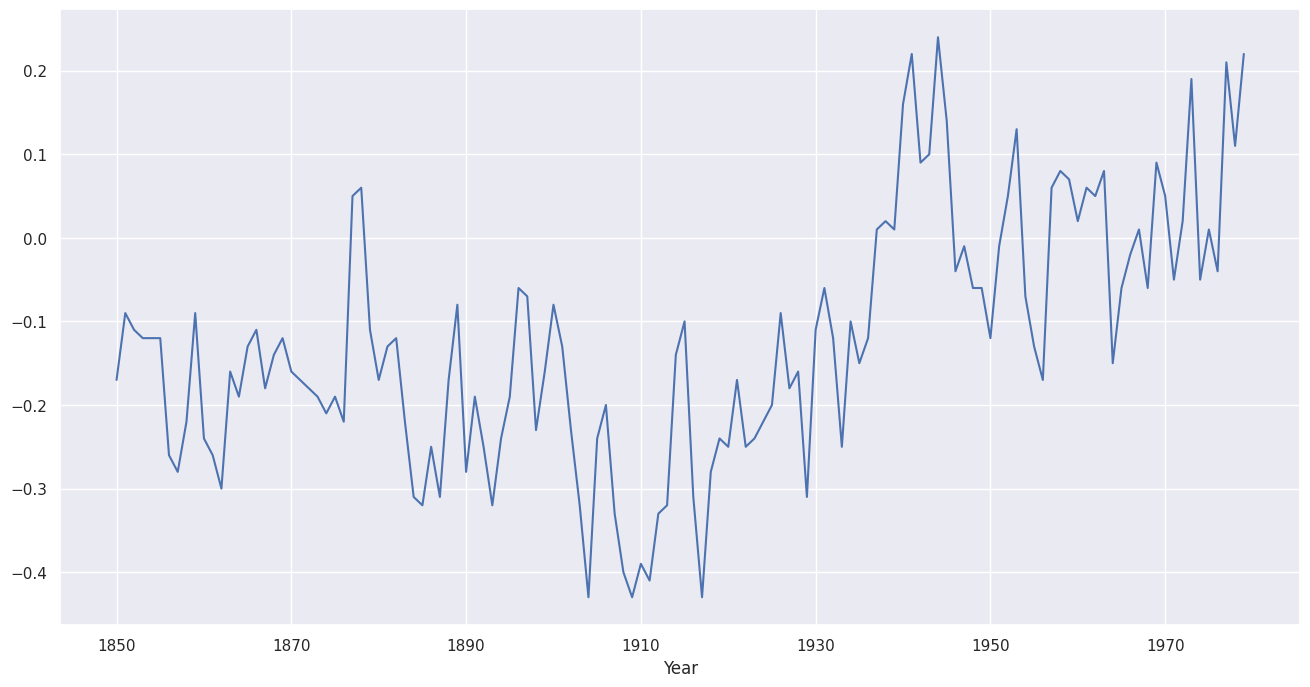

In [47]:
# Train
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

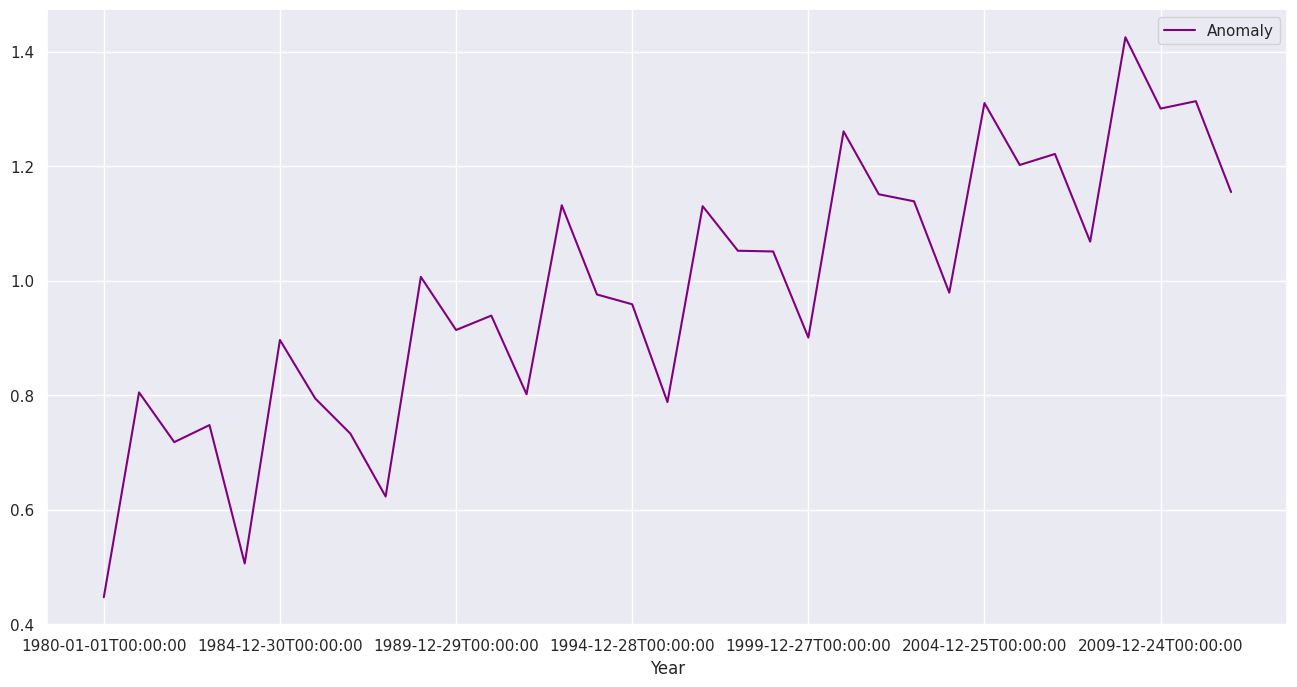

In [48]:
# Forecast
forecast_df['color'] = 'purple'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

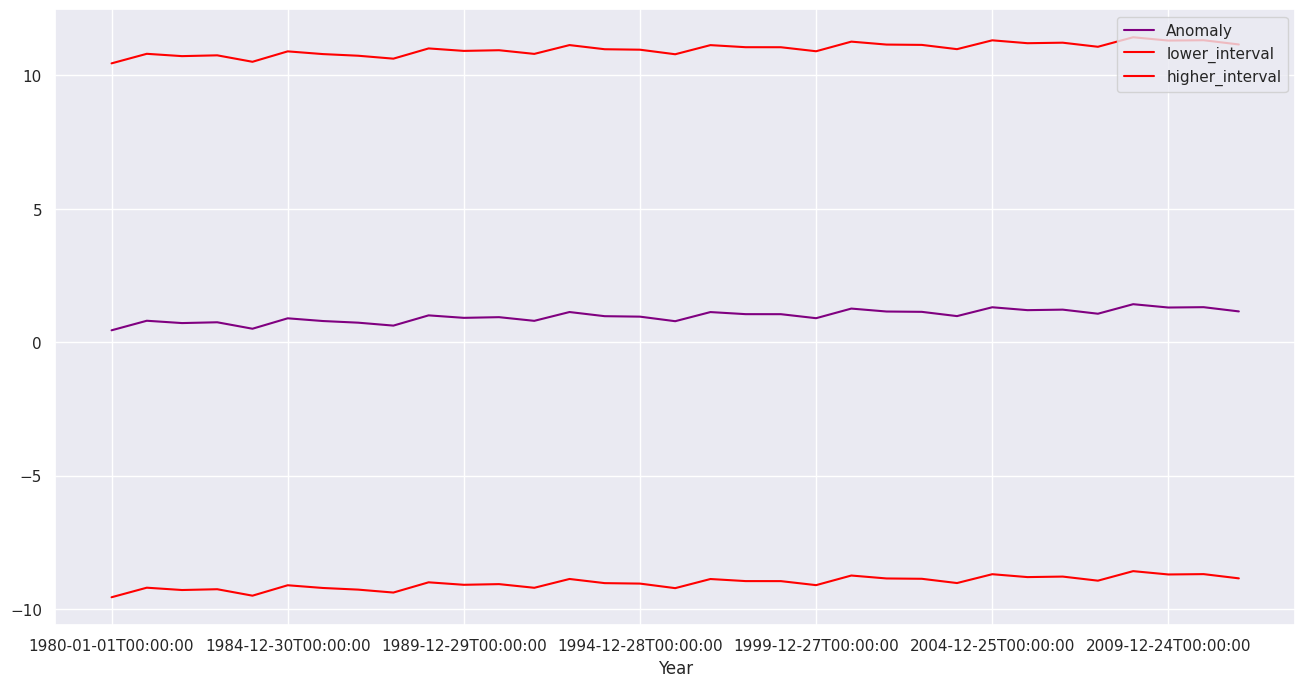

In [49]:
# Probabilistic Forecast (with MAUQ)
uncertainty_colors = ['purple', 'red', 'red']
uncertainty_df.set_index(time_col).plot(figsize=figsize, color=uncertainty_colors);

Combine train and test sets

In [50]:
train_df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [51]:
forecast_df.head()

,Year,Anomaly,color
0,1980-01-01T00:00:00,0.447047,purple
1,1980-12-31T00:00:00,0.804811,purple
2,1981-12-31T00:00:00,0.717996,purple
3,1982-12-31T00:00:00,0.747706,purple
4,1983-12-31T00:00:00,0.506036,purple


In [52]:
uncertainty_df.head()

,Year,Anomaly,lower_interval,higher_interval
0,1980-01-01T00:00:00,0.447047,-9.552953,10.447047
1,1980-12-31T00:00:00,0.804811,-9.195189,10.804811
2,1981-12-31T00:00:00,0.717996,-9.282004,10.717996
3,1982-12-31T00:00:00,0.747706,-9.252294,10.747706
4,1983-12-31T00:00:00,0.506036,-9.493964,10.506036


In [53]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [54]:
df.shape

(163, 12)

In [55]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [56]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
158,2007-12-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.068144,purple
159,2008-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.425047,purple
160,2009-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.300495,purple
161,2010-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.313390,purple
162,2011-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.154707,purple


Plot combined train and test sets with the vertical black line as the cut-off

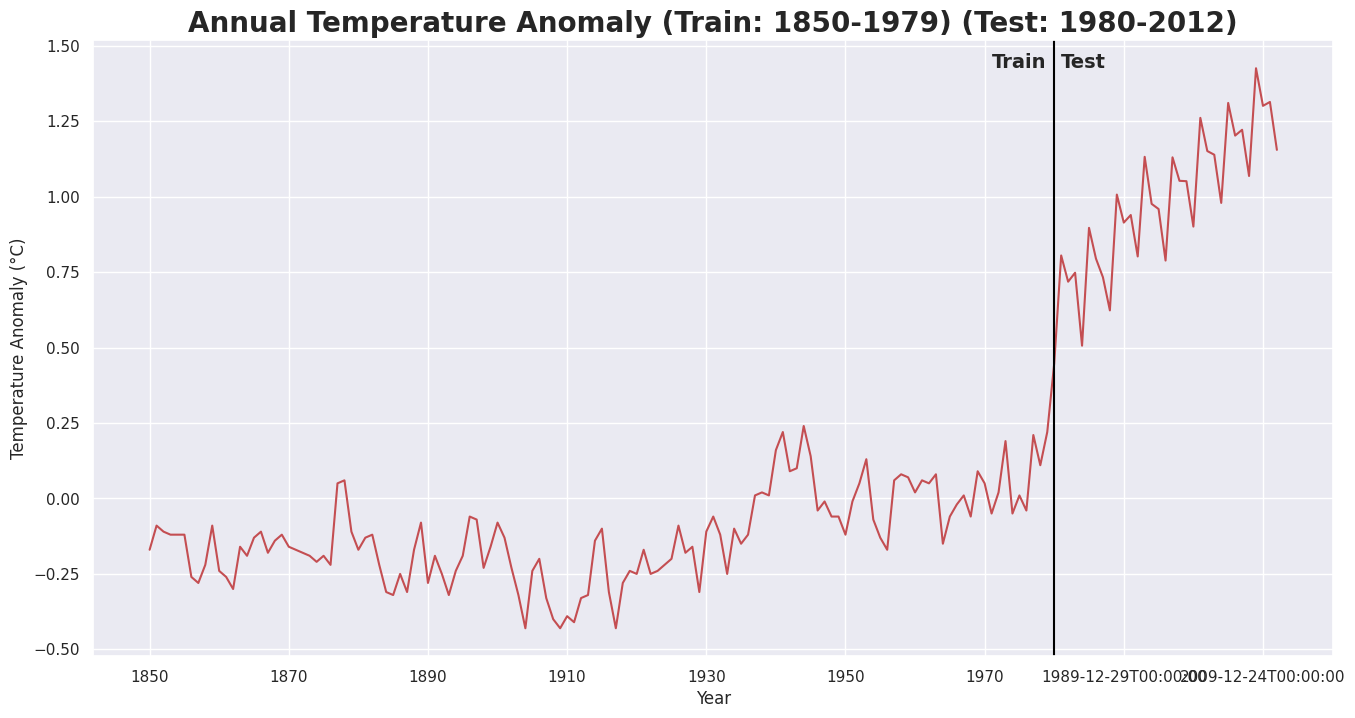

In [57]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Test: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset to compare

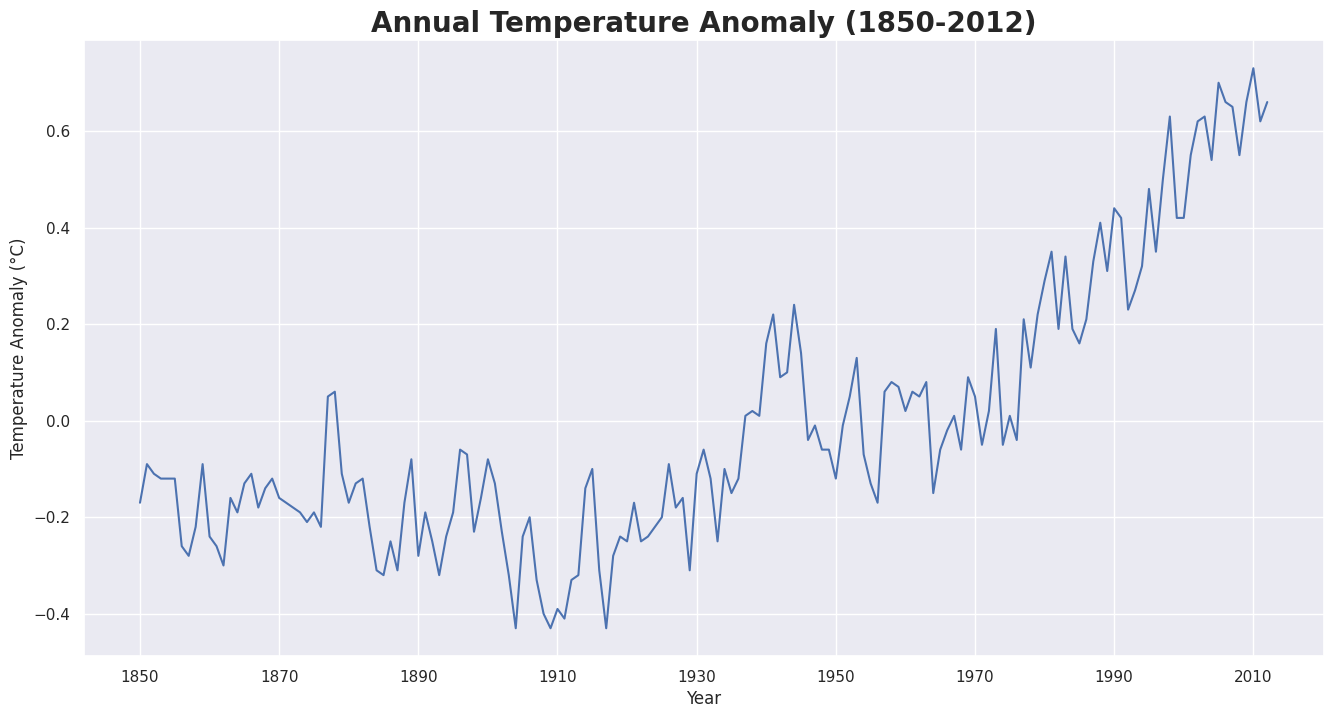

In [58]:
figsize = (16, 8)
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (1850-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset (blue) with SYBIL forecasted values (red)

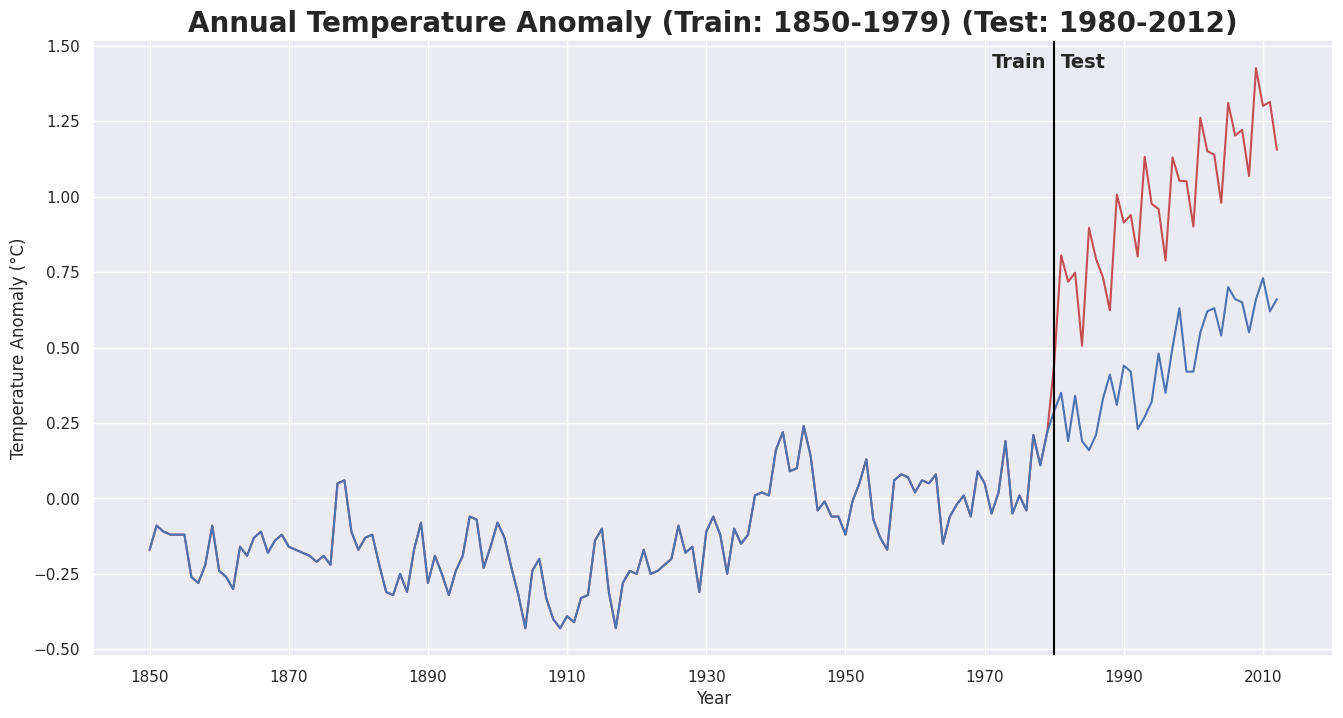

In [59]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Test: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();